<h2>Question 2</h2>

<h3> Loading the data </h3>

In [9]:
import pandas as pd
df_votes = pd.read_csv('votes.csv')
print("Completed loading votes.csv")
df_post = pd.read_csv('posts.csv')
print("Completed loading post.csv")

Completed loading votes.csv
Completed loading post.csv


<h3>Main Processing </h3>

In [24]:
df_post_questions = df_post[df_post['post_type_id'] == 1]
print("Number of questions:",len(df_post_questions)) #Checking the number of questions

df_post_answers = df_post[df_post['post_type_id'] == 2]
print("Number of answers",len(df_post_answers))   #Checking the number of answers

Number of questions: 2012348
Number of answers 4456287


In [17]:
from datetime import datetime
FMT = '%Y-%m-%d %H:%M:%S.%f'

#Making bins with each bin signifing a minute
#Bin responsible for plotting first_answer graph. Like first_answer_bins[10] will have number of 
#questions whos first answer was within first 11 minutes of asking the question.

first_answer_bins=[] 
for i in range(120):
    first_answer_bins.append(int(0))

#Same as first_answer_bins but used for storing number of encounters based on first upvote time.
first_upvoted_bins=[]
for i in range(120):
    first_upvoted_bins.append(int(0))

#For storing number of questions processed, each is taking some time so looping throught all the question 
#will require quit a bit of time.
number_of_questions=0 

#Here the limit for processing the questions is hard set to 10000 
#as its taking too long to process through millions of data entries.
for i in range(1000): 
    if( i%10==0): #Keeping track of the progress
        print(i,"/",len(df_post)," processed")
    number_of_questions=number_of_questions+1
    row = df_post_questions.iloc[i]
    post_creation_time=row.creation_date #Question creation time
    root_id=row.id #Question ID
    df_post_question_answers = df_post_answers[df_post_answers['parent_id'] == root_id] #Answers of the required question
    indexes_to_be_dropped=[]
    
    first_bin_updated=0 #Flag to only count the first answer
    first_upvote_bin_updated=0 #Flag to only count the first upvote
    
    #Looping through answers for furhter processing
    for j in range(len(df_post_question_answers)):
            row = df_post_question_answers.iloc[j]
            answer_creation_time=row.creation_date
            #Removing the T in the creation time and subtracting question creation time from it to get response time
            tdelta = datetime.strptime(answer_creation_time.replace("T"," "),FMT) - datetime.strptime(post_creation_time.replace("T"," "),FMT)
            if(tdelta.seconds>7199): #Excluding answers where response time was greater then 2 hrs ie. 7200 Seconds
                indexes_to_be_dropped.append(j) 
            else:
                pass
                #Updating the first_answer_bins as per first answer time 
                temp=int(tdelta.seconds/60)
                if(first_bin_updated==0): #Limiting first_answer_bins input to the first encounter ie.first answer time
                    first_answer_bins[temp]=first_answer_bins[temp]+1
                    first_bin_updated=1
                else:
                    pass
                row_post_id=row.id
                #Checking for upvote on the answer
                if((df_votes['post_id'] == row_post_id) & (df_votes['vote_type_id'] == 2)).any():
                    if(first_upvote_bin_updated==0): #limiting the first_upvoted_bins input to the first upvote time for the given question 
                        first_upvoted_bins[temp]=first_upvoted_bins[temp]+1
                        first_upvote_bin_updated=1
                        
print("Total number of questions ",number_of_questions)

#Aggrgating the bins such that it represents the sum total of all like first_answer_bins[20] was originally having count 
#of encounters where first answer time was between 20 and 21 minutes. But after this processing it will have all encounters 
#where first encounter time is less then 21 minutes.
first_answer_bins_updated=[]
for i in range(120):
    sums=first_answer_bins[i]
    for j in range(i):
        sums=sums+first_answer_bins[j]
    first_answer_bins_updated.append(sums)
print("First Answers array")
print(first_answer_bins_updated)

print("First Upvotes array")

print("Befor sums:")
print(first_upvoted_bins)

#Same as first_answer_bins aggregation but for first_upvoted_bins
first_upvoted_bins_updated=[]
for i in range(120):
    sums=first_upvoted_bins[i]
    for j in range(i):
        sums=sums+first_upvoted_bins[j]
    first_upvoted_bins_updated.append(sums)
print("After Sums:")
print(first_upvoted_bins_updated)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Total number of questions  1000
First Answers array
[24, 105, 218, 295, 374, 416, 467, 502, 541, 571, 598, 616, 636, 652, 664, 676, 690, 698, 713, 725, 734, 747, 759, 763, 765, 773, 782, 784, 787, 791, 796, 798, 803, 806, 812, 817, 820, 823, 828, 830, 831, 832, 836, 837, 838, 842, 846, 849, 851, 854, 856, 859, 865, 865, 868, 871, 871, 873, 874, 875, 876, 877, 878, 878, 879, 880, 880, 881, 884, 885, 885, 888, 889, 890, 891, 891, 891, 892, 892, 893, 895, 898, 901, 901, 904, 906, 907, 907, 908, 911, 913, 913, 914, 914, 914, 917, 917, 918, 920, 921, 923, 925, 926, 926, 929, 930, 931, 933, 933, 935, 936, 937,

<h3> Ploting the graphs as required</h3>

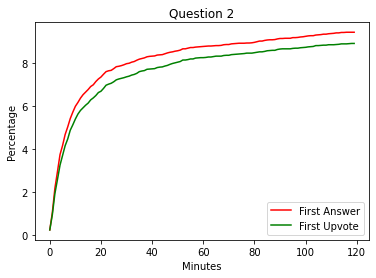

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math
  
x = []
for i in range(120):
    x.append(i)
    
y = first_answer_bins_updated
z = first_upvoted_bins_updated

for i in range(120):
    y[i]=(y[i]/number_of_questions)*100
    z[i]=(z[i]/number_of_questions)*100
# print(y)
# print(z)
# Plotting both the curves simultaneously
plt.plot(x, y, color='r', label='First Answer')
plt.plot(x, z, color='g', label='First Upvote')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Minutes")
plt.ylabel("Percentage")
plt.title("Question 2")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()